In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# 1. Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from pprint import pprint
import regex
import spacy
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Activation, Input, Dense, Dropout, BatchNormalization, \
LSTM, GRU, Bidirectional, Flatten, concatenate, Embedding, Reshape, GlobalAveragePooling1D, \
Attention, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers, regularizers
from sklearn.metrics import plot_roc_curve, roc_curve, \
auc, precision_score, recall_score, confusion_matrix, \
classification_report, accuracy_score, f1_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta

nltk.download('universal_tagset')
nltk.download('punkt')
random.seed(1)

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/stock_prediction/data/All_News.csv')
df.drop(columns=[df.columns[0],df.columns[5]], axis=1, inplace=True)
df.shape

(5681, 5)

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/stock_prediction/data/All_News_update.csv')
df1.drop(columns=[df1.columns[0],df1.columns[5]], axis=1, inplace=True)
df1.shape

(18, 5)

In [ ]:
df = df.append(df1)
df.shape

(5699, 5)

## Filter Company

In [ ]:
df = df[df['company_name'] == 'Amazon']
df.shape

(561, 5)

## Remove Duplicates

In [ ]:
#remove duplicates
nb_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print('# duplicates: ', nb_rows - df.shape[0])

# duplicates:  0


## Missing Value

In [ ]:
#check null
def check_missing_values(row):
    """ functions that check and verifies if there are missing values in dataframe """
    counter = 0
    for element in row:
        if element == True:
            counter+=1
    return ("# Empty entries:", counter)

df.isnull().apply(lambda x: check_missing_values(x)).transpose()

,0,1
Date,# Empty entries:,0
Title,# Empty entries:,0
Url,# Empty entries:,0
Body,# Empty entries:,3
company_name,# Empty entries:,0


## Adjust Published Date

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date
df.head()

,Date,Title,Url,Body,company_name
2156,2021-05-21,Amazon closes US construction site after seven...,https://www.theguardian.com/technology/2021/ma...,<p>Amazon has closed a construction site in Wi...,Amazon
2157,2021-05-18,Amazon in talks to buy Hollywood studio MGM fo...,https://www.theguardian.com/technology/2021/ma...,"<p>Amazon is in talks to acquire MGM, the Holl...",Amazon
2158,2021-05-14,"Amazon creates 10,000 UK jobs on back of onlin...",https://www.theguardian.com/technology/2021/ma...,"<p>Amazon is creating 10,000 permanent jobs in...",Amazon
2159,2021-05-12,Amazon wins appeal over €250m EU tax bill,https://www.theguardian.com/technology/2021/ma...,<p>Amazon has won a court battle against the E...,Amazon
2160,2021-05-11,"Alexa, who are you? New book identifies Amazo...",https://www.theguardian.com/technology/2021/ma...,"<p>The voice of Alexa, the virtual assistant d...",Amazon


In [ ]:
df['wday'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.dayofweek
df

,Date,Title,Url,Body,company_name,wday
2156,2021-05-21,Amazon closes US construction site after seven...,https://www.theguardian.com/technology/2021/ma...,<p>Amazon has closed a construction site in Wi...,Amazon,4
2157,2021-05-18,Amazon in talks to buy Hollywood studio MGM fo...,https://www.theguardian.com/technology/2021/ma...,"<p>Amazon is in talks to acquire MGM, the Holl...",Amazon,1
2158,2021-05-14,"Amazon creates 10,000 UK jobs on back of onlin...",https://www.theguardian.com/technology/2021/ma...,"<p>Amazon is creating 10,000 permanent jobs in...",Amazon,4
2159,2021-05-12,Amazon wins appeal over €250m EU tax bill,https://www.theguardian.com/technology/2021/ma...,<p>Amazon has won a court battle against the E...,Amazon,2
2160,2021-05-11,"Alexa, who are you? New book identifies Amazo...",https://www.theguardian.com/technology/2021/ma...,"<p>The voice of Alexa, the virtual assistant d...",Amazon,1
...,...,...,...,...,...,...
8,2021-06-07,Jeff Bezos to go into space on first crewed fl...,https://www.theguardian.com/technology/2021/ju...,<p>Jeff Bezos will no longer be the richest pe...,Amazon,0
9,2021-06-06,"Global G7 deal may let Amazon off hook on tax,...",https://www.theguardian.com/technology/2021/ju...,<p>Experts have raised concerns that Amazon ma...,Amazon,6
10,2021-06-04,Amazon fired him – now he’s trying to unionize...,https://www.theguardian.com/technology/2021/ju...,<p>Christian Smalls has taken on the biggest c...,Amazon,4
11,2021-06-01,Amazon US customers have one week to opt out o...,https://www.theguardian.com/technology/2021/ju...,<p>Amazon customers have one week to opt out o...,Amazon,1


In [ ]:
df.groupby('wday').count()

,Date,Title,Url,Body,company_name
wday,,,,,
0,82,82,82,81,82
1,128,128,128,128,128
2,112,112,112,111,112
3,114,114,114,114,114
4,74,74,74,73,74
5,21,21,21,21,21
6,30,30,30,30,30


In [ ]:
def adjusted_date(row):
    if row['wday'] < 4 or row['wday'] == 6:
        return row['Date'] + timedelta(days=1)
    elif row['wday'] == 5:
        return row['Date'] + timedelta(days=2)
    else:
        return row['Date'] + timedelta(days=3)

In [ ]:
df['adjusted_date'] = df.apply(lambda row: adjusted_date(row), axis=1)
df

,Date,Title,Url,Body,company_name,wday,adjusted_date
2156,2021-05-21,Amazon closes US construction site after seven...,https://www.theguardian.com/technology/2021/ma...,<p>Amazon has closed a construction site in Wi...,Amazon,4,2021-05-24
2157,2021-05-18,Amazon in talks to buy Hollywood studio MGM fo...,https://www.theguardian.com/technology/2021/ma...,"<p>Amazon is in talks to acquire MGM, the Holl...",Amazon,1,2021-05-19
2158,2021-05-14,"Amazon creates 10,000 UK jobs on back of onlin...",https://www.theguardian.com/technology/2021/ma...,"<p>Amazon is creating 10,000 permanent jobs in...",Amazon,4,2021-05-17
2159,2021-05-12,Amazon wins appeal over €250m EU tax bill,https://www.theguardian.com/technology/2021/ma...,<p>Amazon has won a court battle against the E...,Amazon,2,2021-05-13
2160,2021-05-11,"Alexa, who are you? New book identifies Amazo...",https://www.theguardian.com/technology/2021/ma...,"<p>The voice of Alexa, the virtual assistant d...",Amazon,1,2021-05-12
...,...,...,...,...,...,...,...
8,2021-06-07,Jeff Bezos to go into space on first crewed fl...,https://www.theguardian.com/technology/2021/ju...,<p>Jeff Bezos will no longer be the richest pe...,Amazon,0,2021-06-08
9,2021-06-06,"Global G7 deal may let Amazon off hook on tax,...",https://www.theguardian.com/technology/2021/ju...,<p>Experts have raised concerns that Amazon ma...,Amazon,6,2021-06-07
10,2021-06-04,Amazon fired him – now he’s trying to unionize...,https://www.theguardian.com/technology/2021/ju...,<p>Christian Smalls has taken on the biggest c...,Amazon,4,2021-06-07
11,2021-06-01,Amazon US customers have one week to opt out o...,https://www.theguardian.com/technology/2021/ju...,<p>Amazon customers have one week to opt out o...,Amazon,1,2021-06-02


In [ ]:
df.groupby('adjusted_date').count()[['Title']].sort_values(by=['Title'], ascending=False)

,Title
adjusted_date,
2021-02-04,5
2018-04-25,4
2019-02-11,4
2020-01-23,4
2014-06-19,4
...,...
2016-03-16,1
2016-03-14,1
2016-03-10,1


In [ ]:
df_news = df.groupby('adjusted_date')['Title'].apply(' '.join).reset_index()
df_news

,adjusted_date,Title
0,2012-06-13,"Apps Rush: Kennedys, Spotify, Swipe Magazine, ..."
1,2012-08-09,Apple and Amazon patch security flaws exposed ...
2,2012-08-13,Amazon moves engineering hub to east London
3,2012-08-22,Amazon unleashes Glacier service into market f...
4,2012-08-23,Is Twitter anything more than an online echo c...
...,...,...
471,2021-05-27,Amazon buys Hollywood studio MGM in $8.45bn deal
472,2021-06-02,Amazon US customers have one week to opt out o...
473,2021-06-07,"Global G7 deal may let Amazon off hook on tax,..."
474,2021-06-08,Jeff Bezos to go into space on first crewed fl...


In [ ]:
df_news.rename({'adjusted_date': 'Date'}, axis=1, inplace=True)
df_news

,Date,Title
0,2012-06-13,"Apps Rush: Kennedys, Spotify, Swipe Magazine, ..."
1,2012-08-09,Apple and Amazon patch security flaws exposed ...
2,2012-08-13,Amazon moves engineering hub to east London
3,2012-08-22,Amazon unleashes Glacier service into market f...
4,2012-08-23,Is Twitter anything more than an online echo c...
...,...,...
471,2021-05-27,Amazon buys Hollywood studio MGM in $8.45bn deal
472,2021-06-02,Amazon US customers have one week to opt out o...
473,2021-06-07,"Global G7 deal may let Amazon off hook on tax,..."
474,2021-06-08,Jeff Bezos to go into space on first crewed fl...


## Text Tokenization

In [ ]:
#decontract to not create token from special cases.
#For example, "won't" or " can't" can generate tokens as "wo", "ca" which are not removed by stopwords

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#convert to lower case and decontract
df_news['text_decont'] = df_news['Title'].str.lower().apply(lambda x: decontracted(x))

#remove punctuation
df_news['text_no_punc'] = df_news['text_decont'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          476 non-null    object
 1   Title         476 non-null    object
 2   text_decont   476 non-null    object
 3   text_no_punc  476 non-null    object
dtypes: object(4)
memory usage: 15.0+ KB


In [ ]:
# tokenize w/o preprocessing
df_news['tk'] = df_news['text_no_punc'].apply(lambda x: nltk.word_tokenize(x))
df_news.head()

,Date,Title,text_decont,text_no_punc,tk
0,2012-06-13,"Apps Rush: Kennedys, Spotify, Swipe Magazine, ...","apps rush: kennedys, spotify, swipe magazine, ...",apps rush kennedys spotify swipe magazine ...,"[apps, rush, kennedys, spotify, swipe, magazin..."
1,2012-08-09,Apple and Amazon patch security flaws exposed ...,apple and amazon patch security flaws exposed ...,apple and amazon patch security flaws exposed ...,"[apple, and, amazon, patch, security, flaws, e..."
2,2012-08-13,Amazon moves engineering hub to east London,amazon moves engineering hub to east london,amazon moves engineering hub to east london,"[amazon, moves, engineering, hub, to, east, lo..."
3,2012-08-22,Amazon unleashes Glacier service into market f...,amazon unleashes glacier service into market f...,amazon unleashes glacier service into market f...,"[amazon, unleashes, glacier, service, into, ma..."
4,2012-08-23,Is Twitter anything more than an online echo c...,is twitter anything more than an online echo c...,is twitter anything more than an online echo c...,"[is, twitter, anything, more, than, an, online..."


# 2. TF-IDF

In [ ]:
def identity_tokenizer(text):
    return text

tfvec = TfidfVectorizer(lowercase=False, tokenizer=identity_tokenizer)
df_tfvec = tfvec.fit_transform(df_news.tk.tolist()).todense()

In [ ]:
len(tfvec.get_feature_names())

1984

In [ ]:
df_tfvec

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.19598984, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
df_tfidf = pd.DataFrame(df_tfvec)
df_tfidf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983
0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.24946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
472,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
473,0.0,0.19599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143813,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183723,0.0,0.0,0.0,0.0,0.0
474,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
temp = np.empty(df_tfidf.shape[0], dtype=object)
temp[:] = df_tfidf.values.tolist()

In [ ]:
df_temp = pd.DataFrame(temp, columns=['tfidf'])
df_temp

,tfidf
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
471,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
472,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
473,"[0.0, 0.19598984355879878, 0.0, 0.0, 0.0, 0.0,..."
474,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
df_news = df_news.join(df_temp)
df_news.head()

,Date,Title,text_decont,text_no_punc,tk,tfidf
0,2012-06-13,"Apps Rush: Kennedys, Spotify, Swipe Magazine, ...","apps rush: kennedys, spotify, swipe magazine, ...",apps rush kennedys spotify swipe magazine ...,"[apps, rush, kennedys, spotify, swipe, magazin...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2012-08-09,Apple and Amazon patch security flaws exposed ...,apple and amazon patch security flaws exposed ...,apple and amazon patch security flaws exposed ...,"[apple, and, amazon, patch, security, flaws, e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2012-08-13,Amazon moves engineering hub to east London,amazon moves engineering hub to east london,amazon moves engineering hub to east london,"[amazon, moves, engineering, hub, to, east, lo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2012-08-22,Amazon unleashes Glacier service into market f...,amazon unleashes glacier service into market f...,amazon unleashes glacier service into market f...,"[amazon, unleashes, glacier, service, into, ma...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2012-08-23,Is Twitter anything more than an online echo c...,is twitter anything more than an online echo c...,is twitter anything more than an online echo c...,"[is, twitter, anything, more, than, an, online...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Load Stock Price Data

In [ ]:
df_stock = pd.read_csv('/content/drive/MyDrive/stock_prediction/data/Stock Price - AMZN.csv', skiprows=1)
df_stock.head()

,Date,Close
0,5/18/2012 16:00:00,213.85
1,5/21/2012 16:00:00,218.11
2,5/22/2012 16:00:00,215.33
3,5/23/2012 16:00:00,217.28
4,5/24/2012 16:00:00,215.24


In [ ]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'], infer_datetime_format=True).dt.date

In [ ]:
df_stock = df_stock.set_index('Date').join(df_news.set_index('Date'))

In [ ]:
df_stock.reset_index(inplace=True)

## Replace NaN TI-IDF by Zero Vector

In [ ]:
def tfidf_zero(list_):
    if type(list_) == float:
        list_ = np.zeros(len(tfvec.get_feature_names()), dtype=float)
    else:
        list_ = np.array(list_)
    return list_

In [ ]:
df_stock['tfidf_new'] = df_stock['tfidf'].apply(lambda x: tfidf_zero(x))

In [ ]:
df_stock.reset_index(inplace=True)

In [ ]:
df_stock

,index,Date,Close,Title,text_decont,text_no_punc,tk,tfidf,tfidf_new
0,0,2012-05-18,213.85,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2012-05-21,218.11,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,2012-05-22,215.33,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,2012-05-23,217.28,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,2012-05-24,215.24,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
2275,2275,2021-06-04,3206.22,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2276,2276,2021-06-07,3198.01,"Global G7 deal may let Amazon off hook on tax,...","global g7 deal may let amazon off hook on tax,...",global g7 deal may let amazon off hook on tax ...,"[global, g7, deal, may, let, amazon, off, hook...","[0.0, 0.19598984355879878, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.19598984355879878, 0.0, 0.0, 0.0, 0.0,..."
2277,2277,2021-06-08,3264.11,Jeff Bezos to go into space on first crewed fl...,jeff bezos to go into space on first crewed fl...,jeff bezos to go into space on first crewed fl...,"[jeff, bezos, to, go, into, space, on, first, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2278,2278,2021-06-09,3281.15,What caused the internet outage that brought d...,what caused the internet outage that brought d...,what caused the internet outage that brought d...,"[what, caused, the, internet, outage, that, br...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 3. Train-test split

In [ ]:
df_stock = df_stock.fillna('')

In [ ]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'], format='%Y-%m-%d')

train_data = df_stock[df_stock['Date'] < '2020-01-01'].copy()
val_data = df_stock[df_stock['Date'] < '2020-09-01'][df_stock['Date'] > '2019-12-31'].copy()
test_data = df_stock[df_stock['Date'] > '2020-08-31'].copy()

val_data = val_data.set_index('Date')
train_data = train_data.set_index('Date')
test_data = test_data.set_index('Date')

print('Training set:', train_data.shape[0], 'accounted for ',train_data.shape[0]/df_stock.shape[0]*100,'%')
print('Val set:', val_data.shape[0], 'accounted for ',val_data.shape[0]/df_stock.shape[0]*100,'%')
print('Test set:', test_data.shape[0], 'accounted for ',test_data.shape[0]/df_stock.shape[0]*100,'%')

Training set: 1917 accounted for  84.07894736842105 %
Val set: 168 accounted for  7.368421052631578 %
Test set: 195 accounted for  8.552631578947368 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


# 4. Historical Price
## Data normalization

In [ ]:
# Scaling the training set
transform_train = {}
transform_val = {}
transform_test = {}
scaled_aa = {}
scaler = {}

sc = MinMaxScaler(feature_range=(0,1))

aa = np.array(df_stock.Close)
aa = aa.reshape(aa.shape[0],1)

a0 = np.array(train_data.Close)
a1 = np.array(test_data.Close)
a2 = np.array(val_data.Close)

a0 = a0.reshape(a0.shape[0],1)
a1 = a1.reshape(a1.shape[0],1)
a2 = a2.reshape(a2.shape[0],1)

scaled_aa = sc.fit_transform(aa)

transform_train = sc.transform(a0)
transform_test = sc.transform(a1)
transform_val = sc.transform(a2)

scaler = sc
    
del aa
del a0
del a1
del a2

## Windowing Input Data

In [ ]:
#windowing size
n_lags = int(60)

trainset = {}
testset = {}
valset = {}
    
X_train = []
y_train = []
for i in range(n_lags,train_data.shape[0]):
    X_train.append(transform_train[i-n_lags:i])
    y_train.append(transform_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)
trainset["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
trainset["y"] = y_train

X_test = []
y_test = []    
for i in range(n_lags, test_data.shape[0]):
    X_test.append(transform_test[i-n_lags:i])
    y_test.append(transform_test[i])
X_test, y_test = np.array(X_test), np.array(y_test)
testset["X"] = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
testset["y"] = y_test

X_val = []
y_val = []    
for i in range(n_lags, val_data.shape[0]):
    X_val.append(transform_val[i-n_lags:i])
    y_val.append(transform_val[i])
X_val, y_val = np.array(X_val), np.array(y_val)
valset["X"] = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
valset["y"] = y_val

In [ ]:
# Check the shape (again) before start training
arr_buff = []
buff = {}
buff["X_train"] = trainset["X"].shape
buff["y_train"] = trainset["y"].shape
buff["X_test"] = testset["X"].shape
buff["y_test"] = testset["y"].shape
buff["X_val"] = valset["X"].shape
buff["y_val"] = valset["y"].shape
arr_buff.append(buff)

pd.DataFrame(arr_buff)

,X_train,y_train,X_test,y_test,X_val,y_val
0,"(1857, 60, 1)","(1857, 1)","(135, 60, 1)","(135, 1)","(108, 60, 1)","(108, 1)"


# 5. Word Embedding

In [ ]:
import gensim
from gensim.models import Word2Vec
#setting
vector_dim = 750
window_size = 5
min_count = 1
training_iter = 20

#model
word2vec_model = Word2Vec(sentences=df_news.tk.values, size=vector_dim, window=window_size, 
                          min_count=min_count, iter=training_iter)

In [ ]:
#save model in ASCII (word2vec) format
filename = '/content/drive/MyDrive/stock_prediction/AMZN/embedding_word2vec.txt'
word2vec_model.wv.save_word2vec_format(filename, binary=False)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#find the longest tweet and use its length as number of embedding features
maxlen = max([len(s.split()) for s in train_data.text_no_punc[n_lags:]])

#tokenizer, sequence & padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text_no_punc)
xtrain_word_index = tokenizer.word_index
xtrain_sequences = tokenizer.texts_to_sequences(train_data.text_no_punc[n_lags:])
news_train = pad_sequences(xtrain_sequences, maxlen, padding='pre')
news_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text_no_punc[n_lags:].str.lower())
                       ,maxlen, padding='pre')
news_val = pad_sequences(tokenizer.texts_to_sequences(val_data.text_no_punc[n_lags:].str.lower())
                       ,maxlen, padding='pre')

In [ ]:
maxlen

44

In [ ]:
news_train.shape

(1857, 44)

## Load Pre-trained Word Embedding

In [ ]:
#load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, vector_dim))
    # step vocab, store vectors using the Tokenizer's integer mapping
    hits = 0
    misses = 0
    for word, i in vocab.items():
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            weight_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return weight_matrix, vocab_size

# load embedding from pre-trained embedding file
raw_embedding = load_embedding('/content/drive/MyDrive/stock_prediction/AMZN/embedding_word2vec.txt')

# get vectors in the right order
embedding_vectors, vocab_size = get_weight_matrix(raw_embedding, tokenizer.word_index)

Converted 1671 words (1 misses)


# 6. Seq2seq Model with Word2Vec

In [ ]:
%%time
# LSTM architecture
# FIRST BRANCH operates on the first input
# 1st layer with Dropout regularisation
lstm_input = Input(shape=(X_train.shape[1],1))
x = Bidirectional(GRU(units=60, return_sequences=True))(lstm_input)
x = Dropout(0.2)(x)

# 2nd LSTM layer
x = GRU(units=60)(x)
x = Dropout(0.2)(x)

lstm_branch = Model(inputs=lstm_input, outputs=x)

# SECOND BRANCH operates on the first input
embedding_layer = Embedding(vocab_size, vector_dim, weights=[embedding_vectors]
                            ,input_length=maxlen, trainable=False)
sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

y = Bidirectional(GRU(units=64, return_sequences=True))(embedded_sequences)
y = Dropout(0.2)(y)
y = GRU(units=64, return_sequences=True)(y)
y = Dropout(0.2)(y)
y = GRU(units=64)(y)
y = Dropout(0.2)(y)
news_branch = Model(inputs=sequence_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, news_branch.output], name='combined')
# Output layer
z = Dense(25)(combined)
z = Dense(1)(z)
multi_model = Model(inputs=[lstm_branch.input, news_branch.input], outputs=z)

# Compiling
multi_model.compile(optimizer='adam', loss='mean_squared_error')

CPU times: user 2.12 s, sys: 375 ms, total: 2.5 s
Wall time: 6.44 s


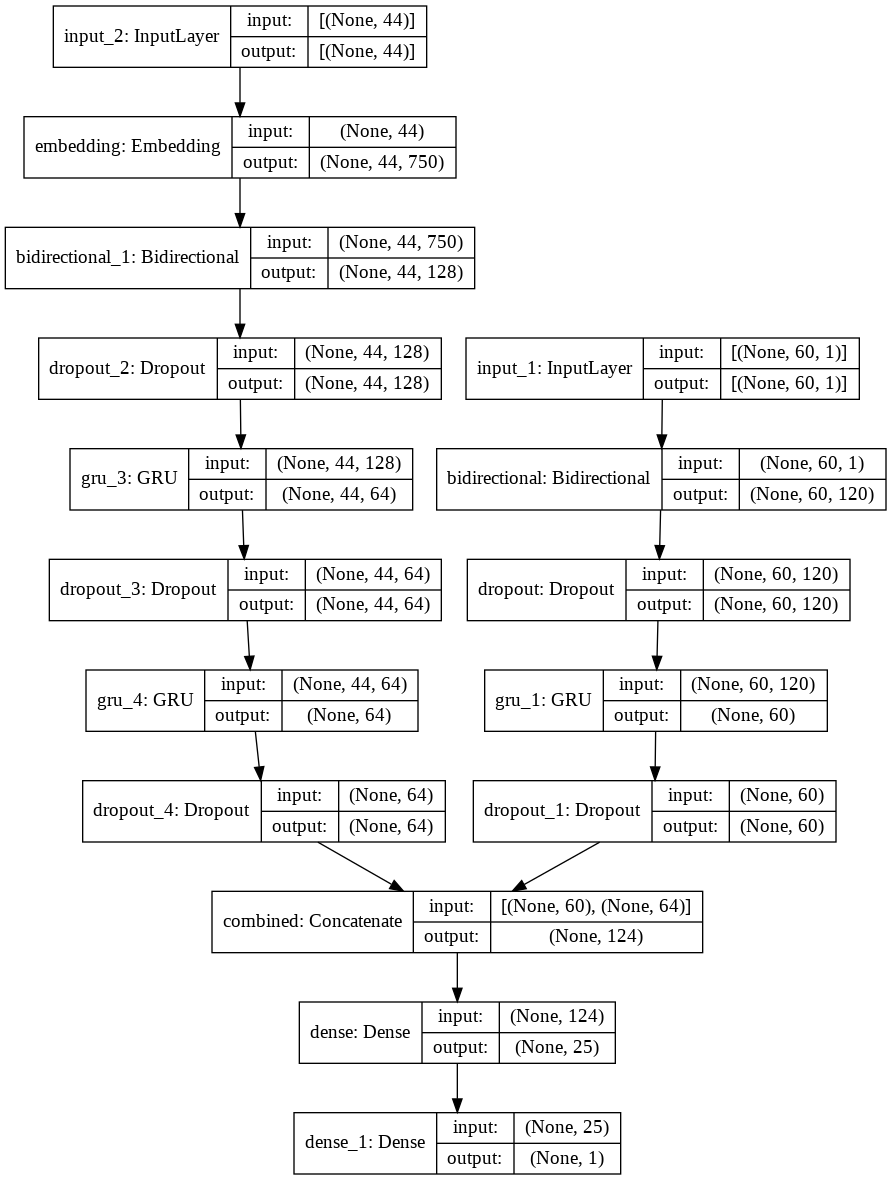

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(multi_model, show_shapes=True)

In [ ]:
from keras.callbacks import CSVLogger
logger_filename = '/content/drive/MyDrive/stock_prediction/AMZN/training_log_seq2seq_model.csv'

my_callback = [
               EarlyStopping(patience=5,monitor='val_loss'),
               CSVLogger(filename=logger_filename)

]

# training setting
epochs = 100
batch_size = 64

# Fitting to the training set
multi_model.fit([trainset['X'], news_train], trainset['y'], epochs=epochs, batch_size=batch_size, callbacks=my_callback
                              , validation_data=([valset['X'], news_val], valset['y']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
30/30 [==============================] - 10s 117ms/step - loss: 0.0212 - val_loss: 0.0052
Epoch 2/100
30/30 [==============================] - 4s 119ms/step - loss: 9.5622e-04 - val_loss: 7.0557e-04
Epoch 3/100
30/30 [==============================] - 4s 119ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 4/100
30/30 [==============================] - 4s 118ms/step - loss: 7.1500e-04 - val_loss: 6.7607e-04
Epoch 5/100
30/30 [==============================] - 4s 118ms/step - loss: 4.3333e-04 - val_loss: 0.0019
Epoch 6/100
30/30 [==============================] - 4s 119ms/step - loss: 5.2051e-04 - val_loss: 4.7364e-04
Epoch 7/100
30/30 [==============================] - 4s 119ms/step - loss: 4.3972e-04 - val_loss: 0.0016
Epoch 8/100
30/30 [==============================] - 4s 118ms/step - loss: 3.3950e-04 - val_loss: 0.0013
Epoch 9/100
30/30 [==============================] - 4s 117ms/step - loss: 4.3130e-04 - val_loss: 5.7559e-04
Epoch 10/100
30/30 [==========================

In [ ]:
multi_model.save('/content/drive/MyDrive/stock_prediction/AMZN/stock_pred_seq2seq_model.h5')

## Evaluation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply t

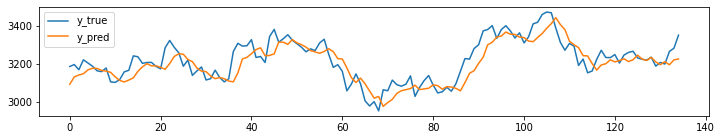

In [ ]:
def calculate_mse_multi(scaler, y_input, x_input, w2v):
    y_pred = multi_model.predict([x_input, w2v])
    MSE = mean_squared_error(y_input, y_pred)

    y_true = scaler.inverse_transform(y_input.reshape(-1,1))
    y_pred = scaler.inverse_transform(y_pred)

    real_mse = np.mean(np.square(y_true - y_pred))
    scaled_mse = real_mse/(np.max(y_true) - np.min(y_true)) * 100

    return MSE, scaled_mse, y_true, y_pred

train_MSE, train_scaled_mse, train_y, train_y_pred = calculate_mse_multi(scaler, trainset["y"], trainset["X"], news_train)
val_MSE, val_scaled_mse, val_y, val_y_pred = calculate_mse_multi(scaler, valset["y"], valset["X"], news_val)
test_MSE, test_scaled_mse, test_y, test_y_pred = calculate_mse_multi(scaler, testset["y"], testset["X"], news_test)

y_true = np.vstack((test_y))
y_pred = np.vstack((test_y_pred))


mse = {}
mse["train"] = train_MSE
mse["val"] = val_MSE
mse["test"] = test_MSE

scaled_mse = {}
scaled_mse["train"] = train_scaled_mse
scaled_mse["val"] = val_scaled_mse
scaled_mse["test"] = test_scaled_mse

pred_result = {}
pred_result["True"] = test_y
pred_result["Pred"] = test_y_pred

plt.figure(figsize=(12,2))
plt.plot(y_true)
plt.plot(y_pred)
plt.legend(['y_true','y_pred'])

In [ ]:
mse

{'test': 0.00034011144766184594,
 'train': 5.0228610714754444e-05,
 'val': 0.000571042282481627}

In [ ]:
scaled_mse

{'test': 723.2248904278695,
 'train': 30.4972589402191,
 'val': 408.3546759547893}

## Prediction

**Definition:**

◦ **Rise (0):** CP of Today > CP of Yesterday , Change Rate > 1.5 %

◦ **Remain Stable (1):** Change Rate ≤ 1.5 %

◦ **Fall (2):** CP of Today < CP of Yesterday , Change Rate > 1.5 %

In [ ]:
pred_df = pd.DataFrame(pred_result['Pred'], columns=['Pred'])
pred_df['True'] = pred_result['True']
pred_df = pred_df.tail(5)
pred_df['His_True'] = pred_result['True'][-6:][:5]
pred_df['His_Pred'] = pred_result['Pred'][-6:][:5]
pred_df['Pred_change_rate'] = (pred_df['Pred'] - pred_df['His_Pred']).abs()/pred_df['His_Pred']*100
pred_df['True_change_rate'] = (pred_df['True'] - pred_df['His_True']).abs()/pred_df['His_True']*100
pred_df

,Pred,True,His_True,His_Pred,Pred_change_rate,True_change_rate
130,3194.441162,3206.22,3187.01,3209.249756,0.461435,0.602759
131,3210.461426,3198.01,3206.22,3194.441162,0.501504,0.256065
132,3194.115723,3264.11,3198.01,3210.461426,0.509139,2.066910
133,3219.742676,3281.15,3264.11,3194.115723,0.802318,0.522041
134,3224.546875,3349.65,3281.15,3219.742676,0.149211,2.087683


In [ ]:
def change_type_pred(row):
    if row['Pred'] > row['His_Pred'] and row['Pred_change_rate'] > 1.5:
        return 0
    elif row['Pred'] < row['His_Pred'] and row['Pred_change_rate'] > 1.5:
        return 2
    else:
        return 1

def change_type_true(row):
    if row['True'] > row['His_True'] and row['True_change_rate'] > 1.5:
        return 0
    elif row['True'] < row['His_True'] and row['True_change_rate'] > 1.5:
        return 2
    else:
        return 1

pred_df['Pred_change_type'] = pred_df.apply(lambda row : change_type_pred(row), axis=1)
pred_df['True_change_type'] = pred_df.apply(lambda row : change_type_true(row), axis=1)

In [ ]:
pred_df

,Pred,True,His_True,His_Pred,Pred_change_rate,True_change_rate,Pred_change_type,True_change_type
130,3194.441162,3206.22,3187.01,3209.249756,0.461435,0.602759,1,1
131,3210.461426,3198.01,3206.22,3194.441162,0.501504,0.256065,1,1
132,3194.115723,3264.11,3198.01,3210.461426,0.509139,2.066910,1,0
133,3219.742676,3281.15,3264.11,3194.115723,0.802318,0.522041,1,1
134,3224.546875,3349.65,3281.15,3219.742676,0.149211,2.087683,1,0


# 7. Baseline Model

In [ ]:
%%time
# The LSTM architecture
regressorBiLSTM = Sequential()
# 1st layer with Dropout regularisation
regressorBiLSTM.add(Bidirectional(GRU(units=60, return_sequences=True), input_shape=(X_train.shape[1],1)))
regressorBiLSTM.add(Dropout(0.2))

# 2nd LSTM layer
regressorBiLSTM.add(GRU(units=60))
regressorBiLSTM.add(Dropout(0.2))

# Output layer
regressorBiLSTM.add(Dense(25))
regressorBiLSTM.add(Dense(units=1))

# Compiling LSTM 
regressorBiLSTM.compile(optimizer='adam', loss='mean_squared_error')
regressorBiLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 60, 120)           22680     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 120)           0         
_________________________________________________________________
gru_6 (GRU)                  (None, 60)                32760     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1525      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 56,991
Trainable params: 56,991
Non-trainable params: 0
____________________________________________________

In [ ]:
logger_filename = '/content/drive/MyDrive/stock_prediction/AMZN/training_log_bilstm_model.csv'

my_callback = [
               EarlyStopping(patience=5,monitor='val_loss'),
               CSVLogger(filename=logger_filename)

]

# training setting
epochs = 100
batch_size = 64

# Fitting to the training set
regressorBiLSTM.fit(trainset['X'], trainset['y'], epochs=epochs, batch_size=batch_size, callbacks=my_callback
                              , validation_data=(valset['X'], valset['y']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
30/30 [==============================] - 2s 64ms/step - loss: 0.0156 - val_loss: 0.0048
Epoch 2/100
30/30 [==============================] - 2s 62ms/step - loss: 0.0011 - val_loss: 5.7856e-04
Epoch 3/100
30/30 [==============================] - 2s 61ms/step - loss: 6.1871e-04 - val_loss: 8.6259e-04
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 5.3801e-04 - val_loss: 0.0069
Epoch 5/100
30/30 [==============================] - 2s 61ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 5.5528e-04 - val_loss: 8.3197e-04
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 4.0631e-04 - val_loss: 7.7906e-04


In [ ]:
regressorBiLSTM.save('/content/drive/MyDrive/stock_prediction/AMZN/stock_pred_bilstm_model.h5')

## Evaluation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply t

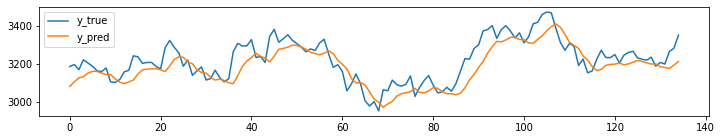

In [ ]:
def calculate_mse(scaler, y_input, x_input):
    y_pred = regressorBiLSTM.predict(x_input)
    MSE = mean_squared_error(y_input, y_pred)

    y_true = scaler.inverse_transform(y_input.reshape(-1,1))
    y_pred = scaler.inverse_transform(y_pred)

    real_mse = np.mean(np.square(y_true - y_pred))
    scaled_mse = real_mse/(np.max(y_true) - np.min(y_true)) * 100

    return MSE, scaled_mse, y_true, y_pred

train_MSE, train_scaled_mse, train_y, train_y_pred = calculate_mse(scaler, trainset["y"], trainset["X"])
val_MSE, val_scaled_mse, val_y, val_y_pred = calculate_mse(scaler, valset["y"], valset["X"])
test_MSE, test_scaled_mse, test_y, test_y_pred = calculate_mse(scaler, testset["y"], testset["X"])

y_true = np.vstack((test_y))
y_pred = np.vstack((test_y_pred))


mse = {}
mse["train"] = train_MSE
mse["val"] = val_MSE
mse["test"] = test_MSE

scaled_mse = {}
scaled_mse["train"] = train_scaled_mse
scaled_mse["val"] = val_scaled_mse
scaled_mse["test"] = test_scaled_mse

plt.figure(figsize=(12,2))
plt.plot(y_true)
plt.plot(y_pred)
plt.legend(['y_true','y_pred'])

In [ ]:
mse

{'test': 0.0004345111451245637,
 'train': 5.926994556893453e-05,
 'val': 0.000779061777585839}

In [ ]:
scaled_mse

{'test': 923.9593105289069,
 'train': 35.986885738316836,
 'val': 557.1100952672532}

# 8. Full-connected Network with TF-IDF
## Headlines Input Preparation

In [ ]:
train_data.head()

,index,Close,Title,text_decont,text_no_punc,tk,tfidf,tfidf_new
Date,,,,,,,,
2012-05-18,0,213.85,,,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012-05-21,1,218.11,,,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012-05-22,2,215.33,,,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012-05-23,3,217.28,,,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012-05-24,4,215.24,,,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
train_news = np.matrix(train_data.tfidf_new[n_lags:].tolist())
#train_news = train_news.reshape(train_news.shape[0],1)

val_news = np.matrix(val_data.tfidf_new[n_lags:].tolist())
#val_news = val_news.reshape(val_news.shape[0],1)

test_news = np.matrix(test_data.tfidf_new[n_lags:].tolist())
#test_news = test_news.reshape(test_news.shape[0],1)

In [ ]:
print('News to train:',train_news.shape)
print('\nNews to test:',test_news.shape)
print('\nNews to val:',val_news.shape)

News to train: (1857, 1984)

News to test: (135, 1984)

News to val: (108, 1984)


## Model

In [ ]:
%%time
# LSTM architecture
# FIRST BRANCH operates on the first input
# 1st layer with Dropout regularisation
lstm_input = Input(shape=(X_train.shape[1],1))
x = Bidirectional(GRU(units=60, return_sequences=True))(lstm_input)
x = Dropout(0.2)(x)

# 2nd LSTM layer
x = GRU(units=60)(x)
x = Dropout(0.2)(x)

lstm_branch = Model(inputs=lstm_input, outputs=x)

# SECOND BRANCH operates on the first input
dense_input = Input(shape=(len(tfvec.get_feature_names()),))
y = Dense(50)(dense_input)
y = Dropout(0.2)(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')
# Output layer
z = Dense(25)(combined)
z = Dense(units=1)(z)
multi_model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

# Compiling
multi_model.compile(optimizer='adam', loss='mean_squared_error')

CPU times: user 815 ms, sys: 26.1 ms, total: 841 ms
Wall time: 834 ms


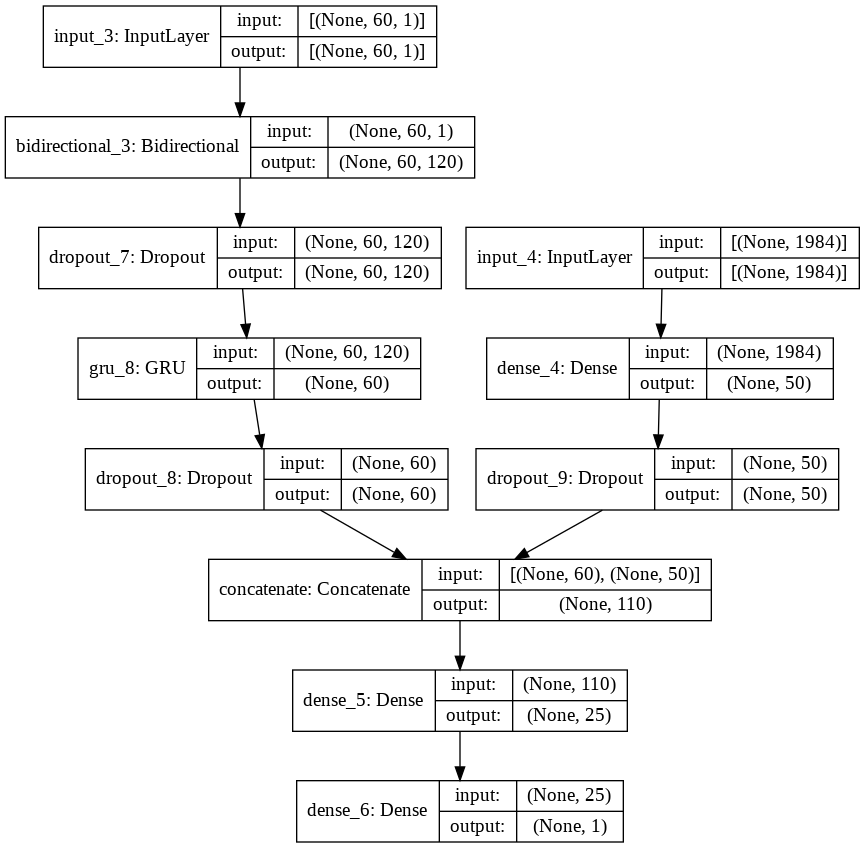

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(multi_model, show_shapes=True)

In [ ]:
from keras.callbacks import CSVLogger
logger_filename = '/content/drive/MyDrive/stock_prediction/AMZN/training_log_fc_model.csv'

my_callback = [
               EarlyStopping(patience=5,monitor='val_loss'),
               CSVLogger(filename=logger_filename)

]

# training setting
epochs = 100
batch_size = 64

# Fitting to the training set
multi_model.fit([trainset['X'], train_news], trainset['y'], epochs=epochs, batch_size=batch_size, callbacks=my_callback
                              , validation_data=([valset['X'], val_news], valset['y']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
30/30 [==============================] - 2s 65ms/step - loss: 0.0278 - val_loss: 9.2964e-04
Epoch 2/100
30/30 [==============================] - 2s 64ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/100
30/30 [==============================] - 2s 65ms/step - loss: 7.4147e-04 - val_loss: 0.0010
Epoch 4/100
30/30 [==============================] - 2s 66ms/step - loss: 5.8898e-04 - val_loss: 6.5699e-04
Epoch 5/100
30/30 [==============================] - 2s 64ms/step - loss: 6.3830e-04 - val_loss: 0.0015
Epoch 6/100
30/30 [==============================] - 2s 65ms/step - loss: 4.6101e-04 - val_loss: 0.0013
Epoch 7/100
30/30 [==============================] - 2s 65ms/step - loss: 4.3039e-04 - val_loss: 5.8288e-04
Epoch 8/100
30/30 [==============================] - 2s 64ms/step - loss: 4.2586e-04 - val_loss: 6.9912e-04
Epoch 9/100
30/30 [==============================] - 2s 66ms/step - loss: 3.8280e-04 - val_loss: 0.0013
Epoch 10/100
30/30 [==============================] - 2s

In [ ]:
multi_model.save('/content/drive/MyDrive/stock_prediction/AMZN/stock_pred_fc_model.h5')

## Evaluation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply t

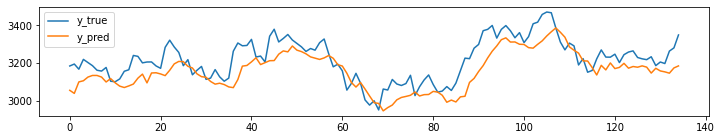

In [ ]:
def calculate_mse_multi(scaler, y_input, x_input, tfidf):
    y_pred = multi_model.predict([x_input, tfidf])
    MSE = mean_squared_error(y_input, y_pred)

    y_true = scaler.inverse_transform(y_input.reshape(-1,1))
    y_pred = scaler.inverse_transform(y_pred)

    real_mse = np.mean(np.square(y_true - y_pred))
    scaled_mse = real_mse/(np.max(y_true) - np.min(y_true)) * 100

    return MSE, scaled_mse, y_true, y_pred

train_MSE, train_scaled_mse, train_y, train_y_pred = calculate_mse_multi(scaler, trainset["y"], trainset["X"], train_news)
val_MSE, val_scaled_mse, val_y, val_y_pred = calculate_mse_multi(scaler, valset["y"], valset["X"], val_news)
test_MSE, test_scaled_mse, test_y, test_y_pred = calculate_mse_multi(scaler, testset["y"], testset["X"], test_news)

y_true = np.vstack((test_y))
y_pred = np.vstack((test_y_pred))


mse = {}
mse["train"] = train_MSE
mse["val"] = val_MSE
mse["test"] = test_MSE

scaled_mse = {}
scaled_mse["train"] = train_scaled_mse
scaled_mse["val"] = val_scaled_mse
scaled_mse["test"] = test_scaled_mse

plt.figure(figsize=(12,2))
plt.plot(y_true)
plt.plot(y_pred)
plt.legend(['y_true','y_pred'])

In [ ]:
mse

{'test': 0.0006564028304237173,
 'train': 5.779881614138646e-05,
 'val': 0.0010504938923817423}

In [ ]:
scaled_mse

{'test': 1395.7977564783412,
 'train': 35.093657250479524,
 'val': 751.2122072549504}